# Linear Regression

### Step 1. Loading the data:

In [14]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
df = pd.read_csv('HousingData.csv')
df = df.dropna() #remove rows containing null values. Since our dataset consists fully of features and a target value (without optional inputs like comment), we can drop the rows confidently

### Step 2. EDA

#### Display

In [16]:
print(df.head())
print(df.describe())
print(df.dtypes)

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222     18.7   
5  0.02985   0.0   2.18   0.0  0.458  6.430  58.7  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
5  394.12   5.21  28.7  
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  394.000000  394.000000  394.000000  394.000000  394.000000  394.000000   
mean     3.690136   11.460660   11.000863    0.068528    0.553215    6.280015   
std      9.202423   23.954082    6.908364    0.252971    0.113112    0.697985   
min      0.006320    0.000000    0.460000    

#### Outliers
The algorithm to find outliers is to find an IQR - Inter Quantile Range. Then define a lower and upper boundary with the given formula. Check for each target value (MEDV) to see if it falls in the range we defined or not \
<b>Note: Q1, Q3 and IQR stay constant for the specific column. It would be a lot faster to compute them before the iteration of the column. But if we want to keep it reusable with other columns in future, it is better to keep in the function so that I don't have to define quantiles and the range each time I want to find outliers of columns. Although performance-wise, It would be preferrable to compute in the main </b>

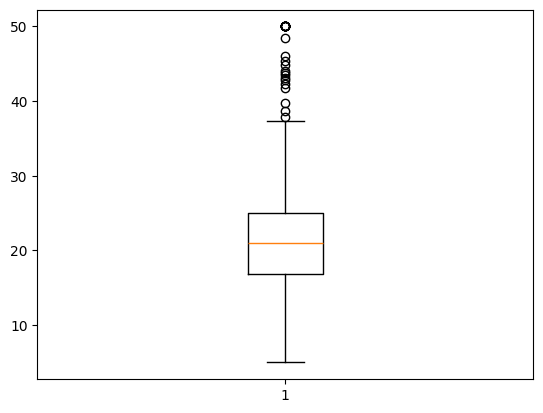

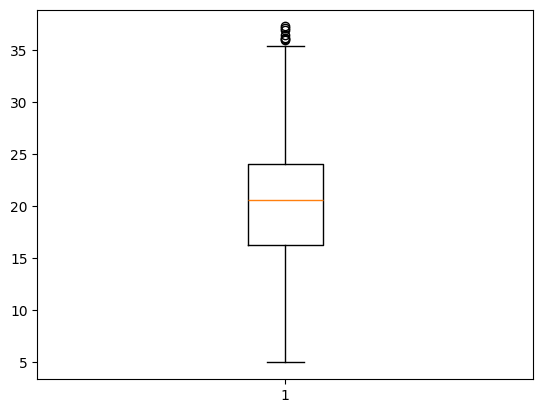

In [17]:
def remove_outlier(col, value):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5* IQR
    upper = Q3 + 1.5 * IQR
    return 1 if value <lower or value > upper else 0

plt.boxplot(df.MEDV) #before outlier removal. Should show more points out of range
plt.show()
df["is_outlier"] = df.MEDV.apply(lambda x: remove_outlier(df.MEDV, x))
df = df[df.is_outlier == 0] #remove the outliers
df.drop(columns=['is_outlier'], inplace=True) #we got rid of the outliers, no need for this column anymore

plt.boxplot(df.MEDV)
plt.show()

#### Visuals
##### Correlation Heatmap

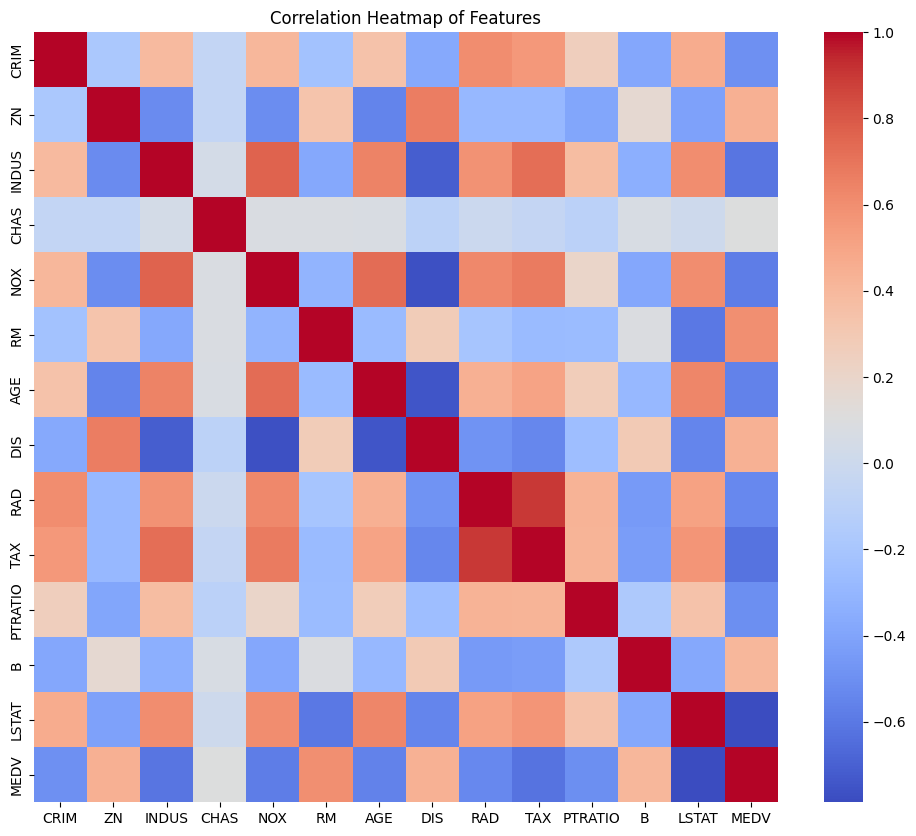

In [18]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap of Features")
plt.show()

##### Histogram of MEDV

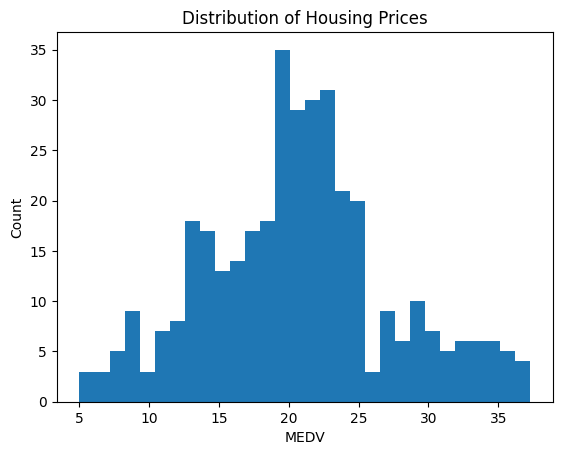

In [19]:
plt.hist(df['MEDV'], bins=30)
plt.xlabel("MEDV")
plt.ylabel("Count")
plt.title("Distribution of Housing Prices")
plt.show()

##### Scatter Plot: MEDV vs RM

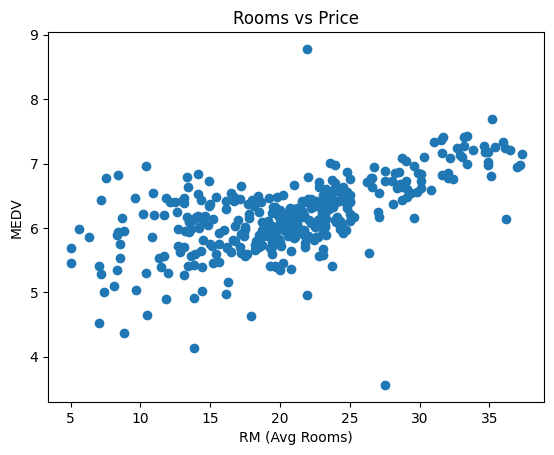

In [20]:
plt.scatter(df['MEDV'], df['RM'])
plt.xlabel("RM (Avg Rooms)")
plt.ylabel("MEDV")
plt.title("Rooms vs Price")
plt.show()

### Step. 3: Preparing the data
This step also includes feature scaling step. But it will be done internally in my LinearReg implementation. Both input and the dataset itself will be standardized before training

In [21]:
X = df.drop(columns=['MEDV']) #everything except target
Y = df['MEDV']

### Step. 4: Linear Regression implementation
#### Linear Regression from scratch
One thing about this part is about loop break condition `if round(dJdw[0], 12) == 0` . This one works, since if we see first one approach 0, it means we are close to minima. But the professional way to handle it is with `if np.linalg.norm(dJdw) < 1e-9`. What it means is that not only partial derivative by bias should be extremely small, but also all other ones should be small (normal of the vector, if coefficients in each direction is small, means smaller norm). I trained both breaking conditions on this dataset and for our case, checking just by bias was more efficient. (13.06% error for my prediction, 13.08% error for the sklearn linear model). Our predictions with sklearn model had an average difference of 0.37%. Using `np.linalg.norm` break condition it was possible to lower this difference (between my prediction and sklearn prediction) to <b>< 1e-8 %</b>. Yet the actual accuracy is better with first one, so I will keep it and all these numbers will be discussed in details in the Analysis.

In [22]:
class LinearReg:
    def __init__(self, alpha = 0.01, normalized = False):
        self.__alpha = alpha
        self.__n_iter = 0
        self.__coeff = None
        self.__normalized = normalized
        self.__weights = None
        self.__bias = None

    def standardize(self, X):
        self.__mean = np.array(X.mean(axis=0))
        std =X.std(axis=0)
        self.__std = np.where(std == 0, 1, std) #to avoid zerodivision error we set std to 1 if we get it 0.
        return (X - self.__mean) / self.__std
    
    def cost(self, X, W, Y):
        pred = X.dot(W)
        loss = (pred - Y)**2
        res = np.sum(loss) / (2 * X.shape[0])
        return res
    
    def fit(self, X, Y):
        if not self.__normalized:
            X = self.standardize(X)
        X_new = np.c_[np.ones(X.shape[0]), X]
        self.__coeff = [np.zeros(X_new.shape[1])][0] #initialize the weights to 0. 
        while True: #since python has no do{} while
            pred = X_new.dot(self.__coeff)
            loss = pred - Y
            dJdw = X_new.T.dot(loss) / X.shape[0]
            self.__coeff = self.__coeff - self.__alpha * dJdw
            self.__n_iter += 1
            if round(dJdw[0], 12) == 0:
                break
        self.__weights = self.__coeff[1:]
        self.__bias = self.__coeff[0]
    def predict(self, X):
        if not self.__normalized:
            X = (X - self.__mean) / self.__std
        pred = X.dot(self.__weights) + self.__bias
        return pred


#### Testing

In [23]:
model = LinearReg()
model.fit(X, Y)
df['my_pred'] = model.predict(X)
print(df.head())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222     18.7   
5  0.02985   0.0   2.18   0.0  0.458  6.430  58.7  6.0622    3  222     18.7   

        B  LSTAT  MEDV    my_pred  
0  396.90   4.98  24.0  27.718150  
1  396.90   9.14  21.6  23.632117  
2  392.83   4.03  34.7  27.507408  
3  394.63   2.94  33.4  26.875317  
5  394.12   5.21  28.7  24.524850  


#### Sklearn built-in linear regression model

In [24]:
from sklearn.linear_model import LinearRegression
sk_model = LinearRegression()
sk_model.fit(X, Y)
df['sk_pred'] = sk_model.predict(X)
print(df[['MEDV', 'sk_pred', 'my_pred']].head())

   MEDV    sk_pred    my_pred
0  24.0  27.574651  27.718150
1  21.6  23.659279  23.632117
2  34.7  27.506233  27.507408
3  33.4  26.845019  26.875317
5  28.7  24.515849  24.524850


#### Analysis
Although the actual accuracy of both models fail to be satisfactory(13.06% error and 13.08% error), the precision of predictions is high - the difference between my and sklearn's predictions is low - 0.37% which shows that the maximum performance of linear regression was observed on this dataset and our implementation was succesful. \
<br>
As discussed in <b>Linear Regression from scratch</b> subheading, a more sophisticated implementation was possible with a break condition of finding normal of the gradient vector. During the training proccess, I observed that normal calculation actually increases the precision of predictions - lowers the difference significantly, but the trade-off is from the actual accuracy. Checking just partial derivative with respect to bias gave more accurate results, so we will keep it that way. So the summary of options is:
1. Calculate the norm to show that our implementation is same as sklearn (get low prediction difference)
2. Check for just the partial derivative by bias since it performs better on this dataset.
<br>
First option is generally considered better. But for this specific dataset second option performed better.

In [25]:
df["Precision_my"] = abs(df['my_pred'] - df['sk_pred']) / df['sk_pred'] * 100 # how much off is my model's prediction from sklearn's prediction
df["Accuracy_my"] = abs(df['my_pred'] - df['MEDV']) / df['MEDV'] * 100 # how much off is my model's prediction from actual value
df["Accuracy_sk"] = abs(df['sk_pred'] - df['MEDV']) / df['MEDV'] * 100 # how much off is sklearn's model's prediction from actual value
print(f"{round(df['Precision_my'].mean(), 3)}% average difference between my model and sklearn model")
print(f"{round(df['Accuracy_my'].mean(), 3)}% average accuracy error of my model")
print(f"{round(df['Accuracy_sk'].mean(), 3)}% average accuracy error of sklearn model") 

0.372% average difference between my model and sklearn model
13.066% average accuracy error of my model
13.079% average accuracy error of sklearn model


### Sources


Matplotlib.Pyplot — Matplotlib 3.5.3 Documentation. https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html. Accessed 18 Nov. 2025.


Overview of Seaborn Plotting Functions — Seaborn 0.13.2 Documentation. https://seaborn.pydata.org/tutorial/function_overview.html. Accessed 18 Nov. 2025.

